## Introducción
Este notebook aborda la clasificación del número de estrellas (1–5) asignadas a una reseña de Amazon a partir de su texto. El flujo general incluye: descarga del dataset, construcción del texto de entrada, particionado en conjuntos de entrenamiento/validación/test, tokenización subword usando el tokenizador de XLM-R, definición de varias arquitecturas MLP basadas en un embedding entrenado desde cero, ejecución de experimentos con distintos hiperparámetros, visualización de curvas y evaluación con métricas (accuracy y F1). A lo largo del documento se explican decisiones, supuestos y limitaciones.

### Objetivo
Predecir la etiqueta (número de estrellas) optimizando la función de pérdida de entropía cruzada y comparar arquitecturas de complejidad creciente.

### Guía rápida de secciones
1. Carga y exploración del dataset
2. Preprocesamiento del texto y creación de etiquetas
3. Conversión a `Dataset` de Hugging Face y splits
4. Tokenización y preparación de tensores
5. Definición de arquitecturas MLP
6. Entrenamiento y ejecución de experimentos
7. Visualización y métricas adicionales
8. Conclusiones y observaciones finales


In [1]:
# Importaciones principales
# En esta celda se cargan las librerías necesarias para:
# - Manipulación de datos: pandas
# - Descarga del dataset desde Kaggle: kagglehub
# - Construcción y entrenamiento de modelos: PyTorch (torch, nn, optim)
# - Métricas: accuracy_score, classification_report (sklearn)
# - Visualización: matplotlib
# - Tokenización y manejo de datasets: datasets (HF) y transformers (AutoTokenizer)

import pandas as pd
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
import copy

from kagglehub import KaggleDatasetAdapter
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer

c:\Users\Laura\OneDrive\Escritorio\NR-project-ARC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga y exploración del dataset
En esta sección se descarga el dataset de reseñas de Amazon usando `kagglehub` y se carga el archivo `train.csv` en un DataFrame de pandas.

### Objetivos
- Verificar forma (número de filas/columnas).
- Inspeccionar nombres de columnas disponibles.
- Observar primeras filas para entender estructura.

In [2]:
# Descargar archivo
file_path = kagglehub.dataset_download("mexwell/amazon-reviews-multi")

csv_path = file_path + "/train.csv"

df = pd.read_csv(csv_path, encoding="latin-1")

print("Shape:", df.shape)
print("Columnas:", df.columns)
print("Primeras 5 filas:\n", df.head())

Shape: (1200000, 9)
Columnas: Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category'],
      dtype='object')
Primeras 5 filas:
    Unnamed: 0   review_id          product_id          reviewer_id  stars  \
0           0  de_0203609  product_de_0865382  reviewer_de_0267719      1   
1           1  de_0559494  product_de_0678997  reviewer_de_0783625      1   
2           2  de_0238777  product_de_0372235  reviewer_de_0911426      1   
3           3  de_0477884  product_de_0719501  reviewer_de_0836478      1   
4           4  de_0270868  product_de_0022613  reviewer_de_0736276      1   

                                         review_body  \
0     Armband ist leider nach 1 Jahr kaputt gegangen   
1                 In der Lieferung war nur Ein Akku!   
2  Ein Stern, weil gar keine geht nicht. Es hande...   
3  Dachte, das wÃ¤ren einfach etwas festere Binde...   
4  Meine Kinder haben kaum damit gespielt u

## Preprocesamiento de texto y creación de etiquetas
Se unifica el título y el cuerpo de la reseña en un único campo `text` para maximizar el contexto disponible. Además, se ajustan las etiquetas de estrellas para que comiencen en 0 (requisito de `CrossEntropyLoss`).

### Detalles
- `text = review_title + ' ' + review_body` con `fillna('')` para evitar valores nulos.
- `labels = stars - 1` transforma el rango [1,5] a [0,4].
- Se conservan solo columnas relevantes: `text`, `labels`, `language`.


In [3]:
# Unificación de título y cuerpo de la reseña + creación de etiquetas normalizadas
# Se genera un único campo de texto para aprovechar todo el contexto disponible.
# Las etiquetas (número de estrellas) se desplazan a rango 0..4, requerido por CrossEntropyLoss.
# Se retienen únicamente columnas necesarias para el modelo.
# Nota: No se hace limpieza adicional (lowercase, eliminar signos, etc.) porque el tokenizador subword maneja vocab enriquecido.

# Combina título y cuerpo (maneja NaN con cadenas vacías)
df["text"] = df["review_title"].fillna("") + " " + df["review_body"].fillna("")
# Ajusta etiquetas al rango 0-4
df["labels"] = df["stars"] - 1
# Subconjunto de columnas relevantes
df = df[["text", "labels", "language"]]

## Conversión a Dataset y particionado (train/validation/test)
Se convierte el DataFrame a un `datasets.Dataset` de Hugging Face y se generan tres subconjuntos:
- `train_dataset`: datos para entrenamiento.
- `validation_dataset`: para monitorear generalización y aplicar early stopping.
- `test_dataset`: evaluación final.

### Detalles
- Primer split: 90% train + 10% test.
- Segundo split: del train original se separa 10% para validación (≈ 9% total).
- Semilla fija `seed=42` para reproducibilidad del particionado.


In [4]:
# Conversión del DataFrame a un objeto Dataset de Hugging Face
# Esto facilita operaciones vectorizadas, mapeo y compatibilidad con DataLoader posteriormente.
# Se crean dos niveles de splits: train/test y luego train/validation.

#Conversión a hugging face dataset
dataset = Dataset.from_pandas(df)

# División del dataset en train y test (10% test)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
# División adicional para generar validación desde el train restante
train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)

# Asignación final de subconjuntos
train_dataset = train_val["train"]
validation_dataset = train_val["test"]
test_dataset = dataset["test"]

## Tokenización y preparación de tensores
Se utiliza el tokenizador subword de `xlm-roberta-base` para segmentar texto multilingüe.

### Parámetros clave
- `truncation=True`: corta reseñas largas para no exceder `max_length`.
- `padding="max_length"`: fija longitud uniforme (facilita batching, pero introduce tokens PAD en reseñas cortas).
- `max_length=180`: compromiso entre cobertura contextual y coste computacional.


In [5]:
# Tokenización subword con el tokenizador de XLM-R
model_name = "xlm-roberta-base"
# Carga del tokenizador multilingüe
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Función de preprocesamiento (mapeable sobre batches)
def preprocess(batch):
  return tokenizer(
      batch["text"],               # Lista de textos
      truncation=True,              # Corta secuencias largas
      padding="max_length",        # Padding uniforme hasta max_length
      max_length=180                # Longitud máxima (hiperparámetro manual)
  )

# Aplicación vectorizada a cada subconjunto
train_dataset = train_dataset.map(preprocess, batched=True)
validation_dataset = validation_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

# Selección de columnas y conversión a tensores de PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "labels"])
validation_dataset.set_format(type="torch", columns=["input_ids", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "labels"])

Map: 100%|██████████| 120000/120000 [00:08<00:00, 14180.52 examples/s]


## Definición de arquitecturas MLP basadas en embeddings
Se definen tres variantes de redes neuronales densas (MLP) que comparten:
- Capa de embeddings entrenada desde cero (dimensión configurable).
- Pooling por promedio sobre la secuencia.
- Capas densas intermedias con activación ReLU y Dropout (0.2).
- Capa final lineal a 5 clases (sin softmax explícito porque `CrossEntropyLoss` lo combina internamente).

### Diferencias principales
- Simple: Menor profundidad y capacidad.
- Intermedia: Tres capas ocultas progresivas.
- Avanzada: Cuatro capas ocultas.

In [6]:
# Definición de tres arquitecturas MLP de distinta profundidad.
# Patrón común:
# 1. Embedding: convierte IDs de subwords en vectores densos entrenables.
# 2. Pooling (mean): colapsa dimensión secuencial -> vector fijo.
# 3. Capas densas con ReLU + Dropout (0.2) para introducir no linealidad y regularización.
# 4. Capa de salida: logits para 5 clases (estrellas 0..4).
# Nota: se usa CrossEntropyLoss posteriormente, por eso no hay Softmax aquí.

class RedNeuronalSimple(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1=128, hidden_dim2=64, output_dim=5, pad_idx=0):
        super(RedNeuronalSimple, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Capa oculta 1
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim1)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # Capa oculta 2
        self.capa_oculta_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # Capa de salida
        self.capa_salida = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)        
        pooled = embedded.mean(dim=1)             
        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)
        x = self.capa_salida(x)                   
        return x

class RedNeuronalIntermedia(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, output_dim=5, pad_idx=0):
        super(RedNeuronalIntermedia, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Capa oculta 1
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim1)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # Capa oculta 2
        self.capa_oculta_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # Capa oculta 3
        self.capa_oculta_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.activacion_3 = nn.ReLU()
        self.dropout_3 = nn.Dropout(0.2)

        # Capa de salida
        self.capa_salida = nn.Linear(hidden_dim3, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)
        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)
        x = self.capa_oculta_3(x)
        x = self.activacion_3(x)
        x = self.dropout_3(x)
        x = self.capa_salida(x)
        return x

class RedNeuronalAvanzada(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1=512, hidden_dim2=256, hidden_dim3=128, hidden_dim4=64, output_dim=5, pad_idx=0):
        super(RedNeuronalAvanzada, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Capa oculta 1
        self.capa_oculta_1 = nn.Linear(embedding_dim, hidden_dim1)
        self.activacion_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        # Capa oculta 2
        self.capa_oculta_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.activacion_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        # Capa oculta 3
        self.capa_oculta_3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.activacion_3 = nn.ReLU()
        self.dropout_3 = nn.Dropout(0.2)

        # Capa oculta 4
        self.capa_oculta_4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.activacion_4 = nn.ReLU()
        self.dropout_4 = nn.Dropout(0.2)

        # Capa de salida
        self.capa_salida = nn.Linear(hidden_dim4, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)
        x = self.capa_oculta_1(pooled)
        x = self.activacion_1(x)
        x = self.dropout_1(x)
        x = self.capa_oculta_2(x)
        x = self.activacion_2(x)
        x = self.dropout_2(x)
        x = self.capa_oculta_3(x)
        x = self.activacion_3(x)
        x = self.dropout_3(x)
        x = self.capa_oculta_4(x)
        x = self.activacion_4(x)
        x = self.dropout_4(x)
        x = self.capa_salida(x)
        return x

def setup_training(model, learning_rate=0.001):
    # Configura Adam como optimizador y CrossEntropy para clasificación multiclase.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

## Funciones de entrenamiento y evaluación (versión 1)
Se definen helpers para entrenar por época, evaluar en validación y un loop principal con early stopping basado en *validation accuracy*.

### Componentes
- `train_epoch`: calcula pérdida media y accuracy en entrenamiento.
- `evaluate_model`: calcula pérdida y accuracy en validación sin gradientes.
- `train_model`: orquesta múltiples épocas, aplica early stopping proporcional al número total de épocas, y guarda el mejor estado del modelo.

In [7]:
# Configuración del dispositivo (GPU si disponible, de lo contrario CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo de entrenamiento: {device}")

# Función de entrenamiento por época
# Recorre todos los batches, acumula pérdida y calcula accuracy acumulado.
# Nota: El embedding se entrena desde cero; grandes batches pueden suavizar gradientes.
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Entrena el modelo por una época y devuelve (loss_media, accuracy)."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        # Datos del batch (input_ids y labels ya en tensores Torch)
        inputs = batch['input_ids'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()              # Limpia gradientes previos
        outputs = model(inputs)            # Forward: logits [batch, num_clases]
        loss = criterion(outputs, labels)  # CrossEntropyLoss (logits + labels enteros)

        loss.backward()                    # Backpropagation
        optimizer.step()                   # Actualiza parámetros

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   # Clase más probable
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

# Función de evaluación (sin actualización de gradientes)
# Calcula pérdida y accuracy en validación para monitorear generalización.
def evaluate_model(model, val_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación y devuelve (loss_media, accuracy)."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Loop principal de entrenamiento con early stopping basado en validation accuracy.
# Guarda el mejor estado (mayor val_accuracy) y detiene si no mejora tras 'patience' épocas.
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, exp_name):
    """Entrenamiento multiepoch con early stopping. Devuelve métricas y mejor modelo."""
    print(f"\n🚀 Iniciando entrenamiento - {model_name} - {exp_name}")
    print("=" * 70)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0

    patience = max(1, int(epochs * 0.10))   # Paciencia proporcional al número máximo de épocas
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\n📊 Época {epoch + 1}/{epochs}")
        print("-" * 50)

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⏳ Sin mejora en val_acc. Paciencia: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"⏹️ Early Stopping activado en época {epoch+1}")
                break

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\n✅ Entrenamiento completado!")
    print(f"🏆 Mejor modelo: Época {best_epoch} con Val Accuracy: {best_val_accuracy:.2f}%")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_epoch': best_epoch,
        'stopped_epoch': epoch +1,
        'model': model
    }

🔧 Dispositivo de entrenamiento: cpu


## Ejecución de experimentos (versión 1)
Se itera sobre las tres arquitecturas definidas y dos configuraciones de hiperparámetros.

### Experimentos
- `exp_1`: lr=0.001, epochs=100, batch=1024
- `exp_2`: lr=0.0005, epochs=500, batch=2048

### Objetivo
Comparar el impacto de profundidad y número de épocas / tamaño de batch sobre la accuracy de validación.

In [8]:
# Bucle maestro de experimentos sobre tres arquitecturas y dos configuraciones de hiperparámetros.
# Nota: Este bloque se replica más adelante con ligera variación; mantener solo una versión en producción facilitaría mantenimiento.

# EJECUCIÓN DE TODOS LOS EXPERIMENTOS
print("🎯 INICIANDO EXPERIMENTOS DE REDES NEURONALES")
print("=" * 80)

# Diccionario de clases de modelos
models_dict = {
    'RedNeuronalSimple': RedNeuronalSimple,
    'RedNeuronalIntermedia': RedNeuronalIntermedia,
    'RedNeuronalAvanzada': RedNeuronalAvanzada
}

# Hiperparámetros por experimento
experiments = {
    "exp_1": {"learning_rate": 0.001, "epochs": 100, "batch_size": 1024},
    "exp_2": {"learning_rate": 0.0005, "epochs": 500, "batch_size": 2048},
}

# Tamaño del vocabulario del tokenizador (embedding entrenado desde cero)
vocab_size = len(tokenizer.vocab)
embedding_dim = 180              # Dimensión de embedding arbitraria elegida
output_dim = 5                   # Número de clases (estrellas 0..4)
pad_idx = tokenizer.pad_token_id # Índice de padding

all_results = {}                 # Almacenará métricas y mejores épocas por modelo/experimento

for model_name, ModelClass in models_dict.items():
    print(f"\n🔬 MODELO: {model_name}")
    print("=" * 60)
    model_results = {}

    for exp_name, params in experiments.items():
        print(f"\n📋 Experimento: {exp_name}")
        print(f"   Parámetros: {params}")

        # DataLoaders con batch_size específico
        train_loader = DataLoader(train_dataset,
                                 batch_size=params["batch_size"],
                                 shuffle=True)
        val_loader = DataLoader(validation_dataset,
                               batch_size=params["batch_size"],
                               shuffle=False)

        # Instanciación (red simple pasa hidden_dim explícito)
        if model_name == "RedNeuronalSimple":
            model = ModelClass(vocab_size, embedding_dim, output_dim=output_dim, pad_idx=pad_idx).to(device)
        elif model_name == "RedNeuronalIntermedia":
            model = ModelClass(vocab_size, embedding_dim, output_dim=output_dim, pad_idx=pad_idx).to(device)
        elif model_name == "RedNeuronalAvanzada":
            model = ModelClass(vocab_size, embedding_dim, output_dim=output_dim, pad_idx=pad_idx).to(device)

        optimizer, criterion = setup_training(model, learning_rate=params["learning_rate"])

        # Entrenamiento y captura de resultados
        results = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            epochs=params["epochs"],
            device=device,
            model_name=model_name,
            exp_name=exp_name
        )

        results['params'] = params
        model_results[exp_name] = results

    all_results[model_name] = model_results

print(f"\n🎉 TODOS LOS EXPERIMENTOS COMPLETADOS")
print("=" * 80)

🎯 INICIANDO EXPERIMENTOS DE REDES NEURONALES

🔬 MODELO: RedNeuronalSimple

📋 Experimento: exp_1
   Parámetros: {'learning_rate': 0.001, 'epochs': 100, 'batch_size': 1024}

🚀 Iniciando entrenamiento - RedNeuronalSimple - exp_1

📊 Época 1/100
--------------------------------------------------
Train Loss: 1.2984 | Train Acc: 41.79%
Val   Loss: 1.1877 | Val   Acc: 47.67%

📊 Época 2/100
--------------------------------------------------
Train Loss: 1.1778 | Train Acc: 48.27%
Val   Loss: 1.1624 | Val   Acc: 48.95%

📊 Época 3/100
--------------------------------------------------
Train Loss: 1.1539 | Train Acc: 49.49%
Val   Loss: 1.1547 | Val   Acc: 49.33%

📊 Época 4/100
--------------------------------------------------
Train Loss: 1.1398 | Train Acc: 50.18%
Val   Loss: 1.1487 | Val   Acc: 49.71%

📊 Época 5/100
--------------------------------------------------
Train Loss: 1.1298 | Train Acc: 50.64%
Val   Loss: 1.1482 | Val   Acc: 49.73%

📊 Época 6/100
---------------------------------------

## Almacenamiento de resultados (versión 1)
Se almacenan los resultados en archivos csv para cada modelo y los experimentos

In [9]:
# GUARDAR RESULTADOS EN ARCHIVOS CSV
print("\n💾 GUARDANDO RESULTADOS EN ARCHIVOS CSV")
print("=" * 60)

import os

# Crear directorio de resultados si no existe
results_dir = "resultados"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"📁 Directorio '{results_dir}' creado")

# Mapeo de nombres de modelos a nombres de archivos
file_mapping = {
    'RedNeuronalSimple': 'resultados_simple.csv',
    'RedNeuronalIntermedia': 'resultados_intermedia.csv',
    'RedNeuronalAvanzada': 'resultados_avanzada.csv'
}

# Guardar resultados de cada modelo
for model_name, model_results in all_results.items():
    # Crear lista para almacenar datos del CSV
    csv_data = []

    print(f"\n📊 Procesando {model_name}...")

    # Procesar cada experimento del modelo
    for exp_name, results in model_results.items():
        params = results['params']

        # Crear fila base con información del experimento
        base_row = {
            'modelo': model_name,
            'experimento': exp_name,
            'learning_rate': params['learning_rate'],
            'epochs_total': params['epochs'],
            'batch_size': params['batch_size'],
            'mejor_epoch': results['best_epoch'],
            'mejor_val_accuracy': results['best_val_accuracy']
        }

        # Agregar métricas por época
        for epoch in range(len(results['train_losses'])):
            row = base_row.copy()
            row.update({
                'epoca': epoch + 1,
                'train_loss': results['train_losses'][epoch],
                'train_accuracy': results['train_accuracies'][epoch],
                'val_loss': results['val_losses'][epoch],
                'val_accuracy': results['val_accuracies'][epoch],
                'es_mejor_modelo': (epoch + 1) == results['best_epoch']
            })
            csv_data.append(row)

    # Convertir a DataFrame y guardar
    df_results = pd.DataFrame(csv_data)

    # Ordenar por experimento y época para mejor lectura
    df_results = df_results.sort_values(['experimento', 'epoca'])

    # Nombre del archivo
    filename = file_mapping[model_name]
    filepath = os.path.join(results_dir, filename)

    # Guardar CSV
    df_results.to_csv(filepath, index=False, encoding='utf-8')

    print(f"   ✅ {filename} guardado ({len(df_results)} filas)")
    print(f"      Columnas: {list(df_results.columns)}")

print(f"\n🎉 TODOS LOS ARCHIVOS CSV GUARDADOS EN '{results_dir}/'")
print("=" * 60)

# Mostrar resumen de archivos creados
print("\n📋 ARCHIVOS CREADOS:")
for model_name, filename in file_mapping.items():
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath)
        print(f"   📄 {filename} ({file_size:,} bytes)")

        # Mostrar preview de las primeras filas
        df_preview = pd.read_csv(filepath, nrows=3)
        print(f"      Preview: {len(df_preview)} filas de muestra")

print(f"\n💡 Para cargar los resultados posteriormente:")
print(f"   df_simple = pd.read_csv('{results_dir}/resultados_simple.csv')")
print(f"   df_intermedia = pd.read_csv('{results_dir}/resultados_intermedia.csv')")
print(f"   df_avanzada = pd.read_csv('{results_dir}/resultados_avanzada.csv')")


💾 GUARDANDO RESULTADOS EN ARCHIVOS CSV

📊 Procesando RedNeuronalSimple...
   ✅ resultados_simple.csv guardado (93 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

📊 Procesando RedNeuronalIntermedia...
   ✅ resultados_intermedia.csv guardado (101 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

📊 Procesando RedNeuronalAvanzada...
   ✅ resultados_avanzada.csv guardado (85 filas)
      Columnas: ['modelo', 'experimento', 'learning_rate', 'epochs_total', 'batch_size', 'mejor_epoch', 'mejor_val_accuracy', 'epoca', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'es_mejor_modelo']

🎉 TODOS LOS ARCHIVOS CSV GUARDADOS EN 'resultados/'

📋 ARC

## Resumen de resultados (versión 1)
Se itera sobre `all_results` para mostrar una tabla en consola con:
- Modelo
- Experimento
- Mejor accuracy de validación
- Época correspondiente
- Learning rate y batch size

In [10]:
# Impresión tabular de los mejores resultados por modelo y experimento.
# Se identifica también el mejor resultado global (highest val accuracy).

# RESUMEN FINAL DE RESULTADOS
print("\n📈 RESUMEN FINAL DE TODOS LOS EXPERIMENTOS")
print("=" * 80)

# Cabecera formateada
print(f"{'Modelo':<20} {'Experimento':<12} {'Val Accuracy':<15} {'Mejor Época':<12} {'LR':<8} {'Batch':<8}")
print("-" * 80)

best_overall = {'accuracy': 0, 'model': '', 'exp': '', 'epoch': 0}

for model_name, model_results in all_results.items():
    for exp_name, results in model_results.items():
        accuracy = results['best_val_accuracy']
        epoch = results['best_epoch']
        lr = results['params']['learning_rate']
        batch_size = results['params']['batch_size']

        print(f"{model_name:<20} {exp_name:<12} {accuracy:<15.2f}% {epoch:<12} {lr:<8} {batch_size:<8}")

        if accuracy > best_overall['accuracy']:
            best_overall['accuracy'] = accuracy
            best_overall['model'] = model_name
            best_overall['exp'] = exp_name
            best_overall['epoch'] = epoch


📈 RESUMEN FINAL DE TODOS LOS EXPERIMENTOS
Modelo               Experimento  Val Accuracy    Mejor Época  LR       Batch   
--------------------------------------------------------------------------------
RedNeuronalSimple    exp_1        50.05          % 14           0.001    1024    
RedNeuronalSimple    exp_2        50.20          % 19           0.0005   2048    
RedNeuronalIntermedia exp_1        50.22          % 14           0.001    1024    
RedNeuronalIntermedia exp_2        50.41          % 27           0.0005   2048    
RedNeuronalAvanzada  exp_1        50.32          % 9            0.001    1024    
RedNeuronalAvanzada  exp_2        50.35          % 16           0.0005   2048    


## Visualización de curvas de entrenamiento
Esta sección carga archivos CSV con métricas por época y traza:
- Pérdida (train vs valid)
- Accuracy (train vs valid)

### Función
`plot_curvas(filepath, titulo, experimento)` filtra por experimento y genera dos figuras.

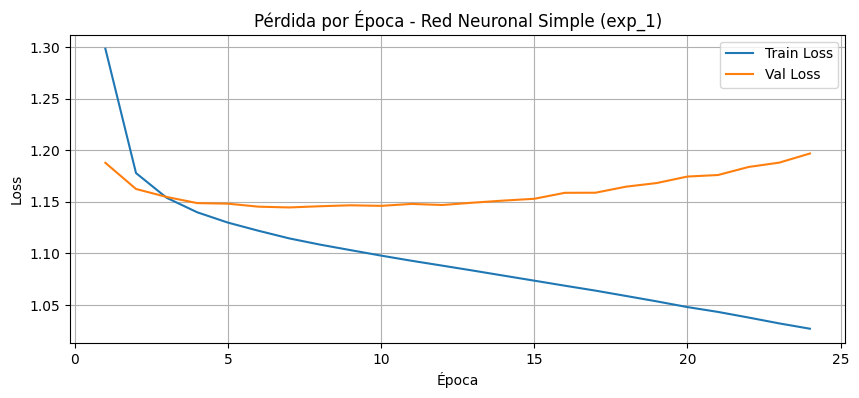

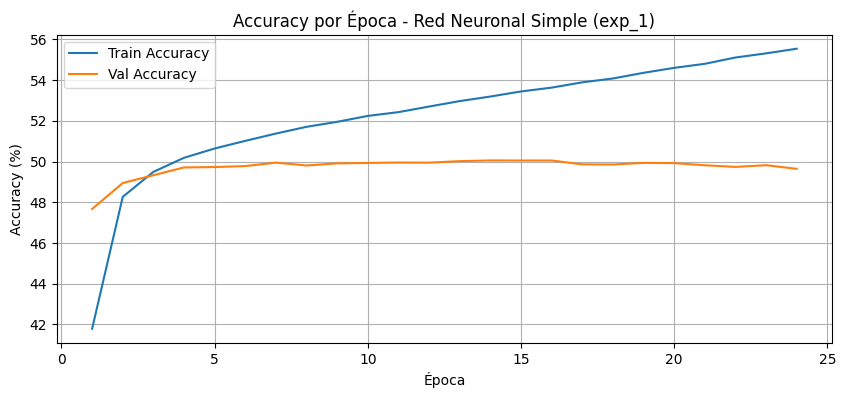

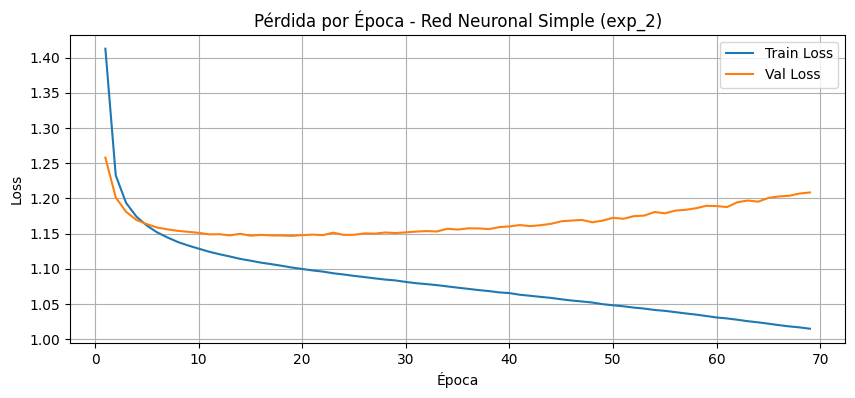

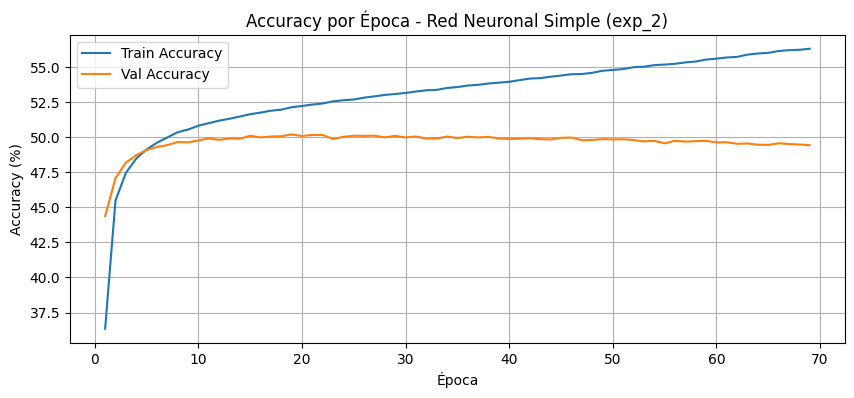

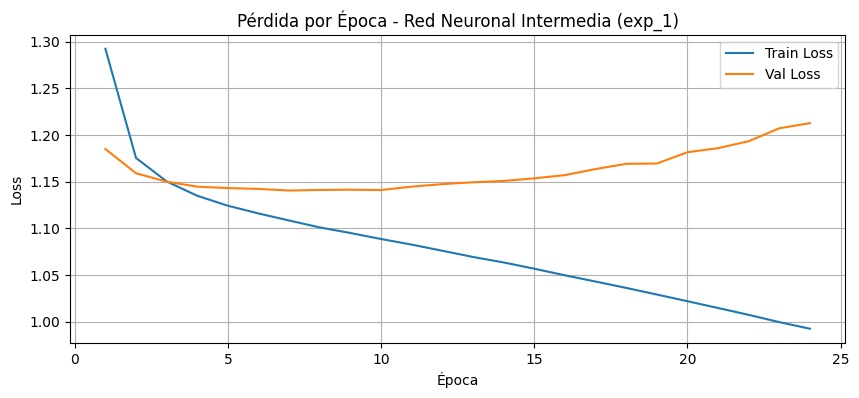

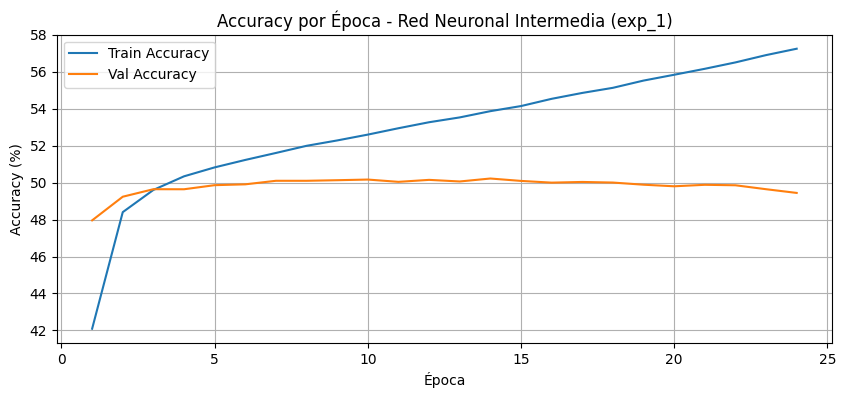

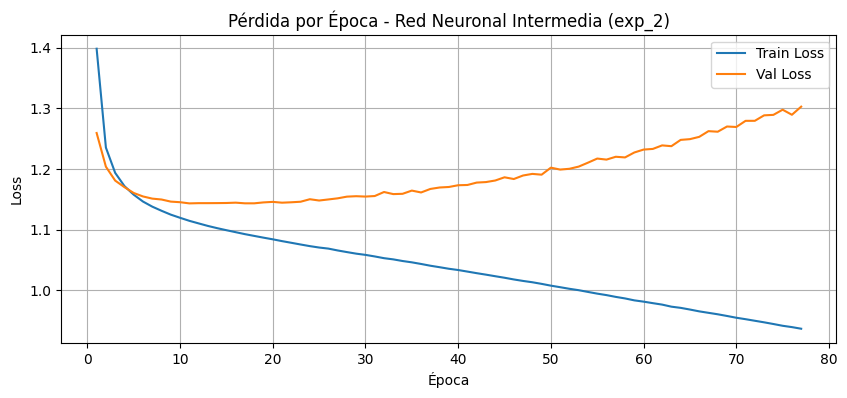

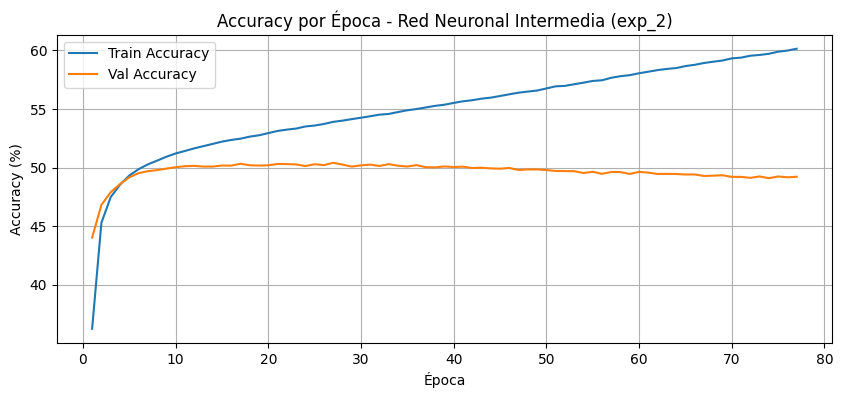

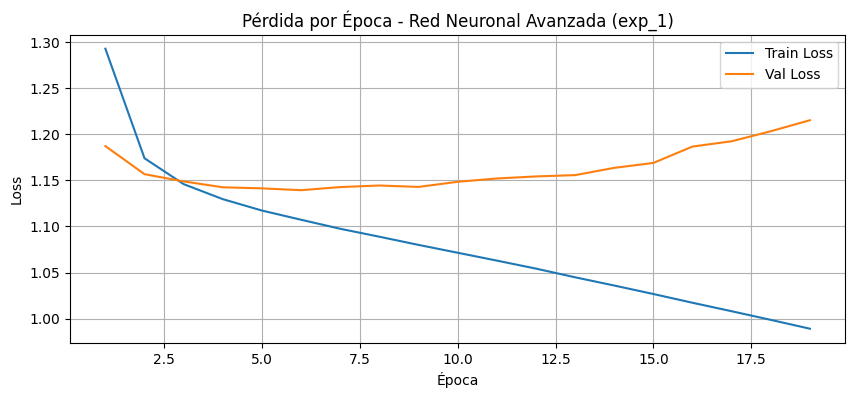

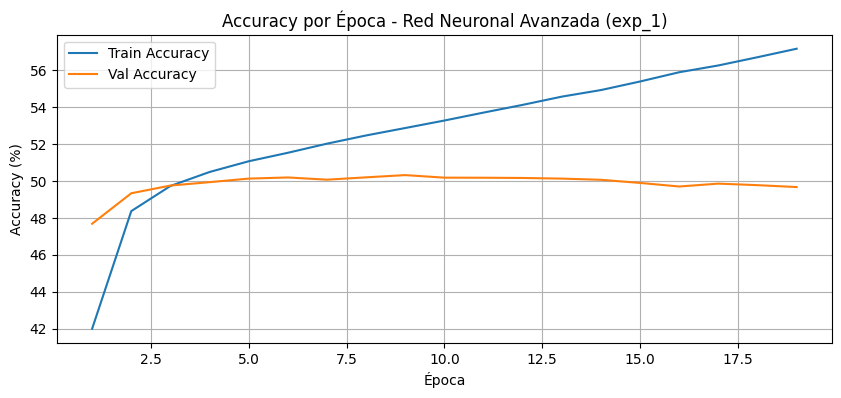

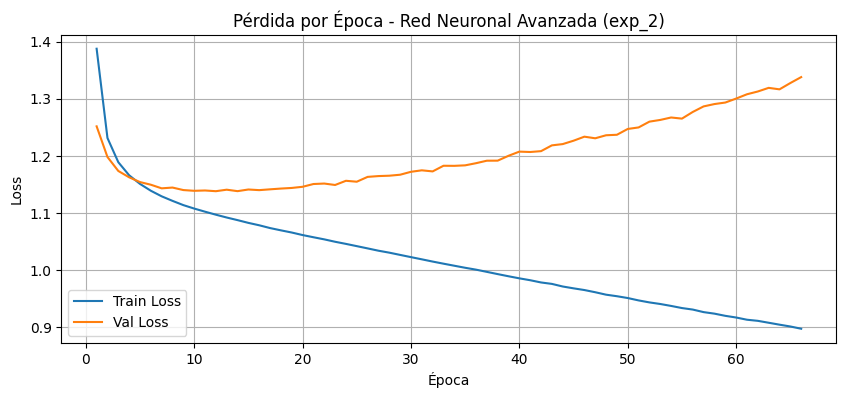

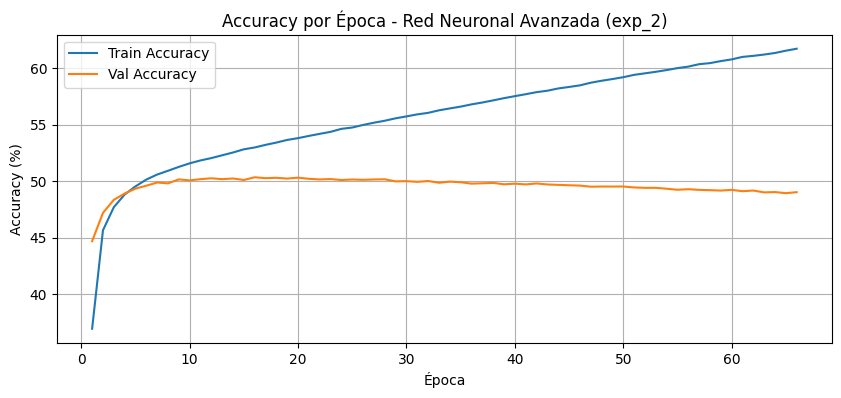

In [ ]:
# Utilidad para visualizar evolución de pérdida y accuracy a partir de CSVs guardados previamente.
# Cada CSV debe contener columnas: epoca, train_loss, val_loss, train_accuracy, val_accuracy, experimento.

import pandas as pd
import matplotlib.pyplot as plt

def plot_curvas(filepath, titulo, experimento):
    # Carga del CSV con resultados históricos
    df = pd.read_csv(filepath)
    # Filtra filas del experimento específico
    df = df[df["experimento"] == experimento]

    # Curva de pérdida (entrenamiento vs validación)
    plt.figure(figsize=(10, 4))
    plt.plot(df["epoca"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoca"], df["val_loss"], label="Val Loss")
    plt.title(f"Pérdida por Época - {titulo} ({experimento})")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Curva de accuracy (entrenamiento vs validación)
    plt.figure(figsize=(10, 4))
    plt.plot(df["epoca"], df["train_accuracy"], label="Train Accuracy")
    plt.plot(df["epoca"], df["val_accuracy"], label="Val Accuracy")
    plt.title(f"Accuracy por Época - {titulo} ({experimento})")
    plt.xlabel("Época")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamadas de ejemplo para cada combinación modelo/experimento
plot_curvas("./resultados/resultados_simple.csv", "Red Neuronal Simple", "exp_1")
plot_curvas("./resultados/resultados_simple.csv", "Red Neuronal Simple", "exp_2")
plot_curvas("./resultados/resultados_intermedia.csv", "Red Neuronal Intermedia", "exp_1")
plot_curvas("./resultados/resultados_intermedia.csv", "Red Neuronal Intermedia", "exp_2")
plot_curvas("./resultados/resultados_avanzada.csv", "Red Neuronal Avanzada", "exp_1")
plot_curvas("./resultados/resultados_avanzada.csv", "Red Neuronal Avanzada", "exp_2")

## Versión 2 del pipeline


## Pipeline modular de entrenamiento y evaluación

Esta sección implementa un pipeline más completo para la experimentación con redes MLP basadas en `nn.Embedding`.  
Incluye:

- **Modelos**: tres variantes (Simple, Intermedia y Avanzada) con capas ocultas dinámicas.
- **Entrenamiento**: ciclo por época, cálculo de métricas y early stopping con paciencia configurable.
- **Evaluación**: métricas adicionales (Accuracy, F1 macro/micro, reporte de clasificación y matriz de confusión).
- **Registro de resultados**: guardado de métricas por época en CSV, con resumen final de mejores resultados.

### Funciones principales
- `train_epoch(...)` y `evaluate_model(...)`: ejecutan entrenamiento y validación de una época.  
- `train_model_es(...)`: entrena el modelo aplicando early stopping.  
- `evaluar_metricas(...)`: calcula métricas finales e imprime matriz de confusión.  
- `guardar_resultados(...)`: guarda los resultados detallados por época en CSV.  
- `mostrar_resumen()`: muestra un consolidado de los mejores experimentos.


In [ ]:
# Segunda versión del pipeline con diseño más modular y métricas ampliadas.
# Incluye: clase base, early stopping con paciencia fija, F1 macro/micro y matriz de confusión.

import os
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# 1. Modelos con nn.Embedding + pooling
# ============================================
class BaseMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_layers, num_classes=5, max_length=180):
        super(BaseMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding entrenado desde cero
        self.max_length = max_length

        layers = []
        input_dim = embedding_dim
        # Construcción dinámica de capas ocultas: Linear + ReLU + Dropout
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_dim = hidden_dim

        # Capa final de clasificación
        layers.append(nn.Linear(input_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        emb = self.embedding(x)            # [batch, seq_len, embedding_dim]
        pooled = emb.mean(dim=1)           # Promedio simple (incluye padding)
        return self.network(pooled)        # Logits

# Constructores ligeros (envoltorios) para cada variante
# Permiten controlar embedding_dim y profundidad desde un solo lugar.
def RedNeuronalSimple(vocab_size, embedding_dim=128):
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[128])

def RedNeuronalIntermedia(vocab_size, embedding_dim=128):
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[256, 128, 64])

def RedNeuronalAvanzada(vocab_size, embedding_dim=128):
    return BaseMLP(vocab_size, embedding_dim, hidden_layers=[512, 256, 128, 64])

# ============================================
# 2. Funciones de entrenamiento y evaluación
# ============================================
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return (
        running_loss / len(val_loader),
        100 * correct / total,
        np.array(all_labels),
        np.array(all_preds)
    )

# ============================================
# 3. Entrenamiento con Early Stopping (paciencia fija)
# ============================================
def train_model_es(model, train_loader, val_loader, optimizer, criterion, epochs, device, patience=None):
    # Paciencia automática = 10% de las épocas si no se pasa manualmente
    if patience is None:
        patience = max(1, int(epochs * 0.1))  # al menos 1

    best_val_accuracy, best_model_state, best_epoch = 0.0, None, 0
    no_improve_epochs = 0

    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

        history["epoch"].append(epoch+1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"📊 Época {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            no_improve_epochs = 0
            print("🌟 Nuevo mejor modelo!")
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"⏹️ Early Stopping activado en época {epoch+1} (paciencia={patience})")
            break

    model.load_state_dict(best_model_state)
    print(f"\n🏆 Mejor modelo en época {best_epoch} con Val Accuracy: {best_val_accuracy:.2f}%")

    return model, best_val_accuracy, best_epoch, pd.DataFrame(history)


# ============================================
# 4. Evaluación final con métricas adicionales
# ============================================
def evaluar_metricas(model, test_loader, criterion, device, nombre_modelo, exp_name):
    model.eval()
    _, acc, y_true, y_pred = evaluate_model(model, test_loader, criterion, device)

    print("\n📊 Evaluación final en Test Set")
    print("Accuracy:", acc)
    print("F1-score Macro:", f1_score(y_true, y_pred, average="macro"))
    print("F1-score Micro:", f1_score(y_true, y_pred, average="micro"))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Matriz de confusión (visión de errores entre clases)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre_modelo} ({exp_name})")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# ============================================
# 5. Guardado de resultados por época
# ============================================
results_dir = "resultados"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

resultados_globales = []  # Acumula resumen de mejores resultados

def guardar_resultados(nombre_modelo, exp_name, params, best_epoch, best_val_accuracy, history):
    filename = f"{nombre_modelo.lower()}_{exp_name}_idioma.csv"
    filepath = os.path.join(results_dir, filename)

    # Enriquecer dataframe de historial con metadatos
    history["modelo"] = nombre_modelo
    history["experimento"] = exp_name
    history["learning_rate"] = params["learning_rate"]
    history["batch_size"] = params["batch_size"]
    history["epochs_total"] = params["epochs"]
    history["mejor_epoch"] = best_epoch
    history["mejor_val_accuracy"] = best_val_accuracy

    history.to_csv(filepath, index=False)
    print(f"✅ Resultados completos guardados en {filepath}")

    resultados_globales.append({
        "modelo": nombre_modelo,
        "experimento": exp_name,
        "lr": params["learning_rate"],
        "batch_size": params["batch_size"],
        "mejor_epoch": best_epoch,
        "mejor_val_accuracy": best_val_accuracy
    })

# ============================================
# 6. Resumen consolidado de mejores resultados
# ============================================
def mostrar_resumen():
    df_resumen = pd.DataFrame(resultados_globales)
    print("\n📈 RESUMEN CONSOLIDADO:")
    print(df_resumen)
    return df_resumen

## Ejecución consolidada de experimentos

En esta sección se entrena y evalúa de forma sistemática las **tres variantes MLP** (Simple, Intermedia y Avanzada) sobre el dataset previamente dividido en *train*, *validation* y *test*.  

Incluye:
- **Configuración del entorno**: selección automática de GPU/CPU y tamaño del vocabulario.  
- **Modelos disponibles**: tres arquitecturas con distinta profundidad.  
- **Experimentos definidos**: parámetros de aprendizaje (epochs, batch size, learning rate).  
- **Entrenamiento**: ejecución con early stopping y registro de métricas.  
- **Evaluación final**: cálculo de Accuracy, F1, matriz de confusión y guardado de resultados en CSV.  
- **Resumen consolidado**: tabla con los mejores resultados de cada combinación modelo/experimento.

### Flujo principal
1. Iterar sobre cada modelo y configuración experimental.  
2. Entrenar con `train_model_es(...)`.  
3. Guardar métricas con `guardar_resultados(...)`.  
4. Evaluar exhaustivamente con `evaluar_metricas(...)`.  
5. Consolidar resultados con `mostrar_resumen()`.  


🔧 Dispositivo de entrenamiento: cpu
📚 Tamaño del vocabulario: 250002

🚀 Entrenando RedNeuronalSimple - exp_1
📊 Época 1/100 | Train Acc: 36.53% | Val Acc: 45.05%
🌟 Nuevo mejor modelo!
📊 Época 2/100 | Train Acc: 46.49% | Val Acc: 47.91%
🌟 Nuevo mejor modelo!
📊 Época 3/100 | Train Acc: 48.22% | Val Acc: 48.38%
🌟 Nuevo mejor modelo!
📊 Época 4/100 | Train Acc: 48.95% | Val Acc: 48.72%
🌟 Nuevo mejor modelo!
📊 Época 5/100 | Train Acc: 49.44% | Val Acc: 48.72%
📊 Época 6/100 | Train Acc: 49.83% | Val Acc: 49.41%
🌟 Nuevo mejor modelo!
📊 Época 7/100 | Train Acc: 50.12% | Val Acc: 49.40%
📊 Época 8/100 | Train Acc: 50.41% | Val Acc: 49.56%
🌟 Nuevo mejor modelo!
📊 Época 9/100 | Train Acc: 50.54% | Val Acc: 49.59%
🌟 Nuevo mejor modelo!
📊 Época 10/100 | Train Acc: 50.84% | Val Acc: 49.57%
📊 Época 11/100 | Train Acc: 50.96% | Val Acc: 49.61%
🌟 Nuevo mejor modelo!
📊 Época 12/100 | Train Acc: 51.11% | Val Acc: 49.73%
🌟 Nuevo mejor modelo!
📊 Época 13/100 | Train Acc: 51.32% | Val Acc: 49.68%
📊 Época 14/10

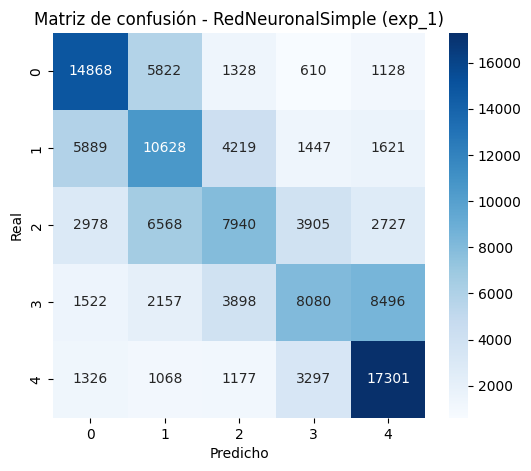


🚀 Entrenando RedNeuronalSimple - exp_2
📊 Época 1/400 | Train Acc: 29.06% | Val Acc: 38.36%
🌟 Nuevo mejor modelo!
📊 Época 2/400 | Train Acc: 40.99% | Val Acc: 43.41%
🌟 Nuevo mejor modelo!
📊 Época 3/400 | Train Acc: 44.82% | Val Acc: 46.26%
🌟 Nuevo mejor modelo!
📊 Época 4/400 | Train Acc: 46.58% | Val Acc: 47.06%
🌟 Nuevo mejor modelo!
📊 Época 5/400 | Train Acc: 47.55% | Val Acc: 47.63%
🌟 Nuevo mejor modelo!
📊 Época 6/400 | Train Acc: 48.18% | Val Acc: 48.31%
🌟 Nuevo mejor modelo!
📊 Época 7/400 | Train Acc: 48.61% | Val Acc: 48.54%
🌟 Nuevo mejor modelo!
📊 Época 8/400 | Train Acc: 49.01% | Val Acc: 48.90%
🌟 Nuevo mejor modelo!
📊 Época 9/400 | Train Acc: 49.22% | Val Acc: 48.74%
📊 Época 10/400 | Train Acc: 49.54% | Val Acc: 49.09%
🌟 Nuevo mejor modelo!
📊 Época 11/400 | Train Acc: 49.77% | Val Acc: 49.32%
🌟 Nuevo mejor modelo!
📊 Época 12/400 | Train Acc: 49.93% | Val Acc: 49.10%
📊 Época 13/400 | Train Acc: 50.06% | Val Acc: 49.42%
🌟 Nuevo mejor modelo!
📊 Época 14/400 | Train Acc: 50.21% | V

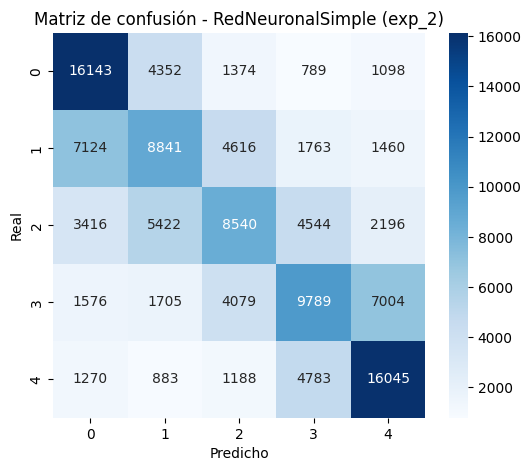


🚀 Entrenando RedNeuronalIntermedia - exp_1
📊 Época 1/100 | Train Acc: 36.94% | Val Acc: 45.47%
🌟 Nuevo mejor modelo!
📊 Época 2/100 | Train Acc: 45.64% | Val Acc: 47.56%
🌟 Nuevo mejor modelo!
📊 Época 3/100 | Train Acc: 47.58% | Val Acc: 48.12%
🌟 Nuevo mejor modelo!
📊 Época 4/100 | Train Acc: 48.38% | Val Acc: 48.68%
🌟 Nuevo mejor modelo!
📊 Época 5/100 | Train Acc: 48.95% | Val Acc: 49.15%
🌟 Nuevo mejor modelo!
📊 Época 6/100 | Train Acc: 49.35% | Val Acc: 48.97%
📊 Época 7/100 | Train Acc: 49.65% | Val Acc: 48.29%
📊 Época 8/100 | Train Acc: 49.87% | Val Acc: 49.56%
🌟 Nuevo mejor modelo!
📊 Época 9/100 | Train Acc: 50.15% | Val Acc: 48.89%
📊 Época 10/100 | Train Acc: 50.27% | Val Acc: 49.36%
📊 Época 11/100 | Train Acc: 50.48% | Val Acc: 49.26%
📊 Época 12/100 | Train Acc: 50.68% | Val Acc: 49.20%
📊 Época 13/100 | Train Acc: 50.83% | Val Acc: 49.58%
🌟 Nuevo mejor modelo!
📊 Época 14/100 | Train Acc: 51.03% | Val Acc: 49.76%
🌟 Nuevo mejor modelo!
📊 Época 15/100 | Train Acc: 51.12% | Val Acc: 4

In [ ]:
# Ejecución consolidada de la segunda versión del pipeline.
# Entrena y evalúa las tres variantes MLP sobre los splits definidos anteriormente.

# ============================================
# 🚀 Entrenamiento de los 3 modelos con dataset en inglés
# ============================================

# Parámetros generales
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Dispositivo de entrenamiento: {device}")

# Tamaño de vocabulario (grande: impacto en memoria y convergencia de embedding)
vocab_size = tokenizer.vocab_size
print(f"📚 Tamaño del vocabulario: {vocab_size}")

# Modelos disponibles (embedding_dim por defecto = 128)
modelos = {
    "RedNeuronalSimple": lambda: RedNeuronalSimple(vocab_size),
    "RedNeuronalIntermedia": lambda: RedNeuronalIntermedia(vocab_size),
    "RedNeuronalAvanzada": lambda: RedNeuronalAvanzada(vocab_size),
}

# Configuraciones experimentales (epochs exp_2 = 400 aquí vs 500 en versión 1)
experimentos = {
    "exp_1": {"learning_rate": 0.001, "epochs": 100, "batch_size": 1024},
    "exp_2": {"learning_rate": 0.0005, "epochs": 400, "batch_size": 2048},
}

# Loop principal sobre modelos y configuraciones
for nombre_modelo, modelo_fn in modelos.items():
    for exp_name, params in experimentos.items():
        print(f"\n🚀 Entrenando {nombre_modelo} - {exp_name}")

        # DataLoaders (shuffle solo en train)
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        val_loader   = DataLoader(validation_dataset, batch_size=params["batch_size"])  # no shuffle
        test_loader  = DataLoader(test_dataset, batch_size=params["batch_size"])        # evaluación

        # Instancia y envío a dispositivo
        modelo = modelo_fn().to(device)
        optimizer = optim.Adam(modelo.parameters(), lr=params["learning_rate"])  # Sin weight decay ni scheduler
        criterion = nn.CrossEntropyLoss()                                          # Pérdida multiclase estándar

        # Entrenamiento con early stopping (paciencia fija = 25)
        modelo, best_val_acc, best_epoch, history = train_model_es(
            modelo, train_loader, val_loader, optimizer, criterion,
            epochs=params["epochs"], device=device, patience=25
        )

        # Guardar historial y metadatos
        guardar_resultados(nombre_modelo, exp_name, params, best_epoch, best_val_acc, history)

        # Evaluación exhaustiva en test (Accuracy + F1 + matriz de confusión)
        evaluar_metricas(modelo, test_loader, criterion, device, nombre_modelo, exp_name)

# Mostrar resumen consolidado final
df_resumen = mostrar_resumen()